In [1]:
from qiskit import execute, BasicAer, QuantumCircuit, QuantumRegister, ClassicalRegister, IBMQ
import math
import numpy as np
import string
import time


In [2]:
#helper function

def simulate(qc, name="q", x="0", n=None, verbose=False, shots=1024):
    backend = BasicAer.get_backend('qasm_simulator')
    if n is None: 
        n = qc.num_qubits

    reg = QuantumRegister(n, name)
    qc2 = QuantumCircuit(reg)
    for i, j in enumerate(x):
        if j == "1": 
            qc2.x(i)
        elif j == "+":
            qc2.h(i)


    qc2 += qc.copy()
    if verbose: 
        print(qc2)
    results = execute(qc2, backend=backend, shots=shots).result()
    return results.get_counts()

In [3]:
#helper function
from qiskit.providers.ibmq import least_busy

def run(qc, dev="best", verbose=False):

    IBMQ.load_account()
    provider = IBMQ.get_provider(hub='ibm-q')
    if dev == "best":
        backend = least_busy(provider.backends(simulator=False))
    else:
        backend = provider.get_backend(dev)


    if verbose: print(backend)
    job_exp = execute(qc, backend=backend, shots=1024)
    exp_result = job_exp.result()
    return exp_result.get_counts(qc)

### 1. Controlled swap gate with |+> as control

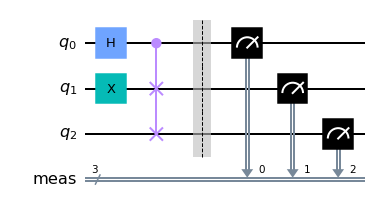

In [4]:

qc = QuantumCircuit(3)
qc.h(0)
qc.x(1)
qc.cswap(0,1,2)
qc.measure_all()
qc.draw(output='mpl')

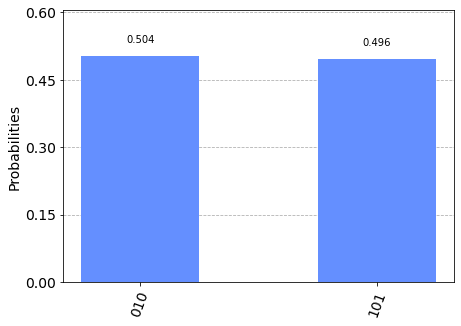

In [5]:
from qiskit.visualization import plot_histogram
plot_histogram(simulate(qc))

#### Half the time the control is 1 and the swap happens
#### Half the time it doesnt

#### This can be used to conditionally measure a qubit:

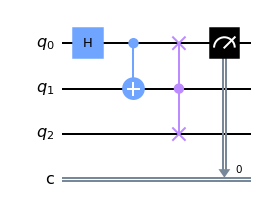

In [6]:
qc = QuantumCircuit(3,1)
qc.h(0)
qc.cx(0,1)
qc.cswap(1,0,2)
qc.measure(0, 0)
qc.draw(output='mpl')

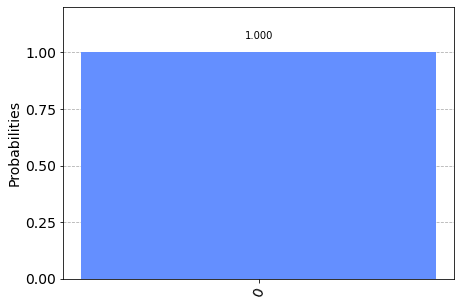

In [7]:
plot_histogram(simulate(qc))

#### measures q0 iff it will be zero. (otherwise doesnt measure anything so result is 0)

#### This is more useful for greater number of qubits. Consider measuring two qubit iff they will are in state |11>

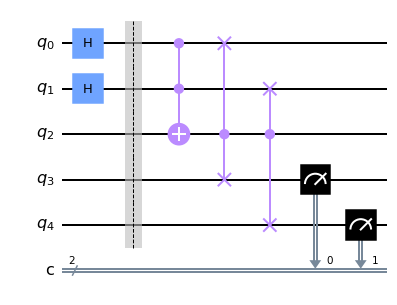

In [8]:
qc = QuantumCircuit(5,2)

qc.h(0)
qc.h(1)

qc.barrier()

qc.ccx(0,1,2)
qc.cswap(2,0,3)
qc.cswap(2,1,4)

qc.measure(3,0)
qc.measure(4,1)

qc.draw(output='mpl')

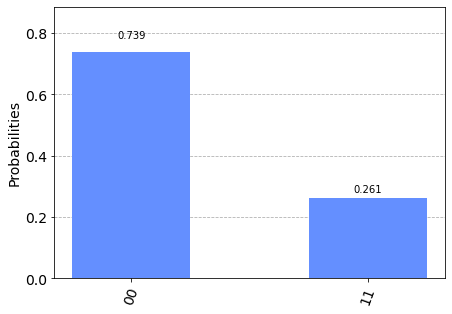

In [9]:
plot_histogram(simulate(qc))

#### It measures 11 1/4 of the time and measures 00 3/4 (when the state is 00, 01 or 10)

#### Question: Is there a way to increase the probability of measuring 11?

#### Answer: Yes! (grover's algorithm)


Helper function which creates grovers circuit assuming oracle is "1" * n

In [53]:
from qiskit.aqua.algorithms import Grover
from qiskit.aqua.components.oracles import CustomCircuitOracle

def get_grovers(n, cm=True, iterations=1, concise=False, track_measure=False):

    if not cm: concise = track_measure = False
        
    if n == 1: track_measure = False

    orac = QuantumCircuit(QuantumRegister(n,name="main"), QuantumRegister(1,name="o"))
    orac.mct(list(range(n)), n)
    
    def classic(x):
        assert type(x) == str, x
        return True, ["1" * n]



    qc = QuantumCircuit()
    
    main = QuantumRegister(n, name="main")
    qc.add_register(main)
  
        
    out = QuantumRegister(1, name="o")
    qc.add_register(out)
    
    if cm:
        if concise:
            b = QuantumRegister(1, name="b")
        else:
            b = QuantumRegister(n, name="b")
        qc.add_register(b)
        cm_reg = QuantumRegister(1, name='cm')
        qc.add_register(cm_reg)
        regs = [cm_reg, main, b]
    qc.add_register(ClassicalRegister(n))


    o = CustomCircuitOracle(variable_register=main, output_register=out, circuit=orac, evaluate_classically_callback=classic)
    
    if not track_measure:
        grov = Grover(o, iterations=iterations)
        
        g = grov.construct_circuit()#.to_gate()
        g.name = "Grover"

        
        qc.append(g, list(range(g.num_qubits)))
    
    else:
        sum_reg = QuantumRegister(n-1, name="sum")
        qc.add_register(sum_reg) #about to mess up the position of everything?
        
        sum_anc = QuantumRegister(1, name="s_an")
        qc.add_register(sum_anc)
        qc.x(sum_anc[0]) #mark at beginning
        for i in range(iterations):
            prep = None
            #if i > 0:
            #    prep = QuantumCircuit(n)
            grov = Grover(o, iterations=1, state_preparation=prep)
        
            g = grov.construct_circuit()
            g.name = "Grover" + str(i)

            qc.append(g, list(range(g.num_qubits)))
            
            qc.barrier()
            
            
            qc.mct(list(range(n)) + [sum_anc[0]], cm_reg[0])
            conditionally_measure(qc, regs, concise=concise)
            
            
            #if not found, increment sum
            qc_add = QuantumCircuit(sum_reg, sum_anc)
            for j in range(len(sum_reg))[::-1]:
                qc_add.mct([sum_anc[0]]+[sum_reg[k] for k in range(j)], sum_reg[j])
            qc_add.name = "increment"
            qc.append(qc_add, list(sum_reg) + list(sum_anc))
            
            qc.cx(cm_reg[0], sum_anc[0]) #check if found
            
            qc.x(sum_anc[0])
            qc.cx(sum_anc[0], cm_reg[0])
            qc.x(sum_anc[0])
            
            #qc.mct(list(b), cm_reg[0])
            #qc.mct(list(main), cm_reg[0])
            #qc.reset(cm_reg[0])
            
            qc.barrier()
              
    #end    
    if cm:
        
        if track_measure:
            #qc.mct(list(range(n)) + [sum_anc[0]], cm_reg[0])
            #conditionally_measure(qc, regs, concise=concise, measure=True)
            qc.measure(b, list(range(len(b))))
            m = len(sum_reg)
            m_reg = ClassicalRegister(m)
            qc.add_register(m_reg)
            qc.measure(sum_reg, m_reg)
        
        else:
            qc.mct(list(range(n)), cm_reg[0])
            conditionally_measure(qc, regs, concise=concise, measure=True)
        
            
    
    else:
        for j in range(n):
            qc.measure(j,j)
        

    return qc


def conditionally_measure(qc, regs, concise, measure=False):
    #qc.mct(list(range(n)), cm[0]) #doing elsewhere
    cm_reg, main, b = regs

    for j in range(0,len(main)):
        if not concise:
            #qc.cswap(qc.num_qubits-1,j,j+n+1)
            #qc.measure(j+n+1,j)
            qc.cswap(cm_reg[0], main[j], b[j])
            if measure: qc.measure(b[j], j)
            
        else:
            #qc.cswap(qc.num_qubits-1,j,n+1)
            #qc.measure(n+1, j)
            qc.cswap(cm_reg[0], main[j], b[0])
            if measure: qc.measure(b[0], j)



For 2 qubits, makes no difference

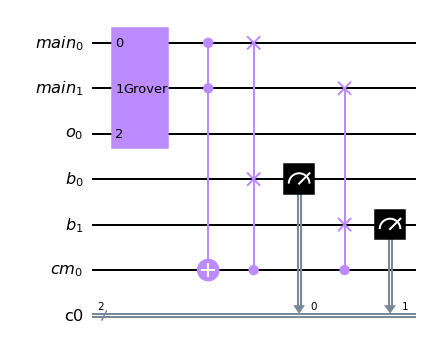

In [11]:
qc = get_grovers(2)
qc.draw(output='mpl')

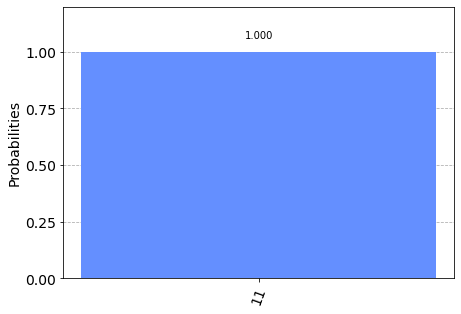

In [12]:
plot_histogram(simulate(qc))

In [13]:
qc = get_grovers(2, cm=False)
qc.draw(output='mpl')

UnboundLocalError: local variable 'cm_reg' referenced before assignment

In [ ]:
plot_histogram(simulate(qc))

### For three qubits, conditional measurement starts to make a difference

In [ ]:
plot_histogram(simulate(get_grovers(3)))

In [ ]:
plot_histogram(simulate(get_grovers(3,False)))

#### The proportion of the correct answer is the same, but all of the incorrect answers are grouped into 000

### This becomes increasingly useful as n increases:

In [ ]:
plot_histogram(simulate(get_grovers(4,False)))

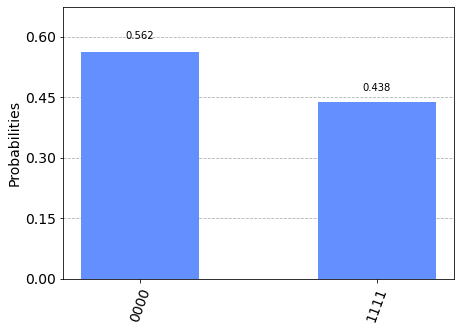

In [14]:
plot_histogram(simulate(get_grovers(4)))

Real devices are too noisy:

In [82]:
plot_histogram(run(get_grovers(3,cm=True,concise=True), dev="ibmq_santiago"))

/Users/edwinagnew/opt/anaconda3/envs/qiskit/lib/python3.7/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


TranspilerError: 'Number of qubits (6) in circuit630474 is greater than maximum (5) in the coupling_map'

### Part 2 - keep track of when the right answer is measured

Basic idea is:
1. Take circuit from before and add new sum register and sum ancilla (s_an) which begins as |1>
2. Apply grovers iteration
3. Cswap main qubits to b register, controlled by grover's oracle again and sum ancilla
4. If swap occurs, flip sum ancilla. This prevents any further swaps and any further increments
5. Increment sum registers by value in sum ancilla
6. Repeat for i iterations

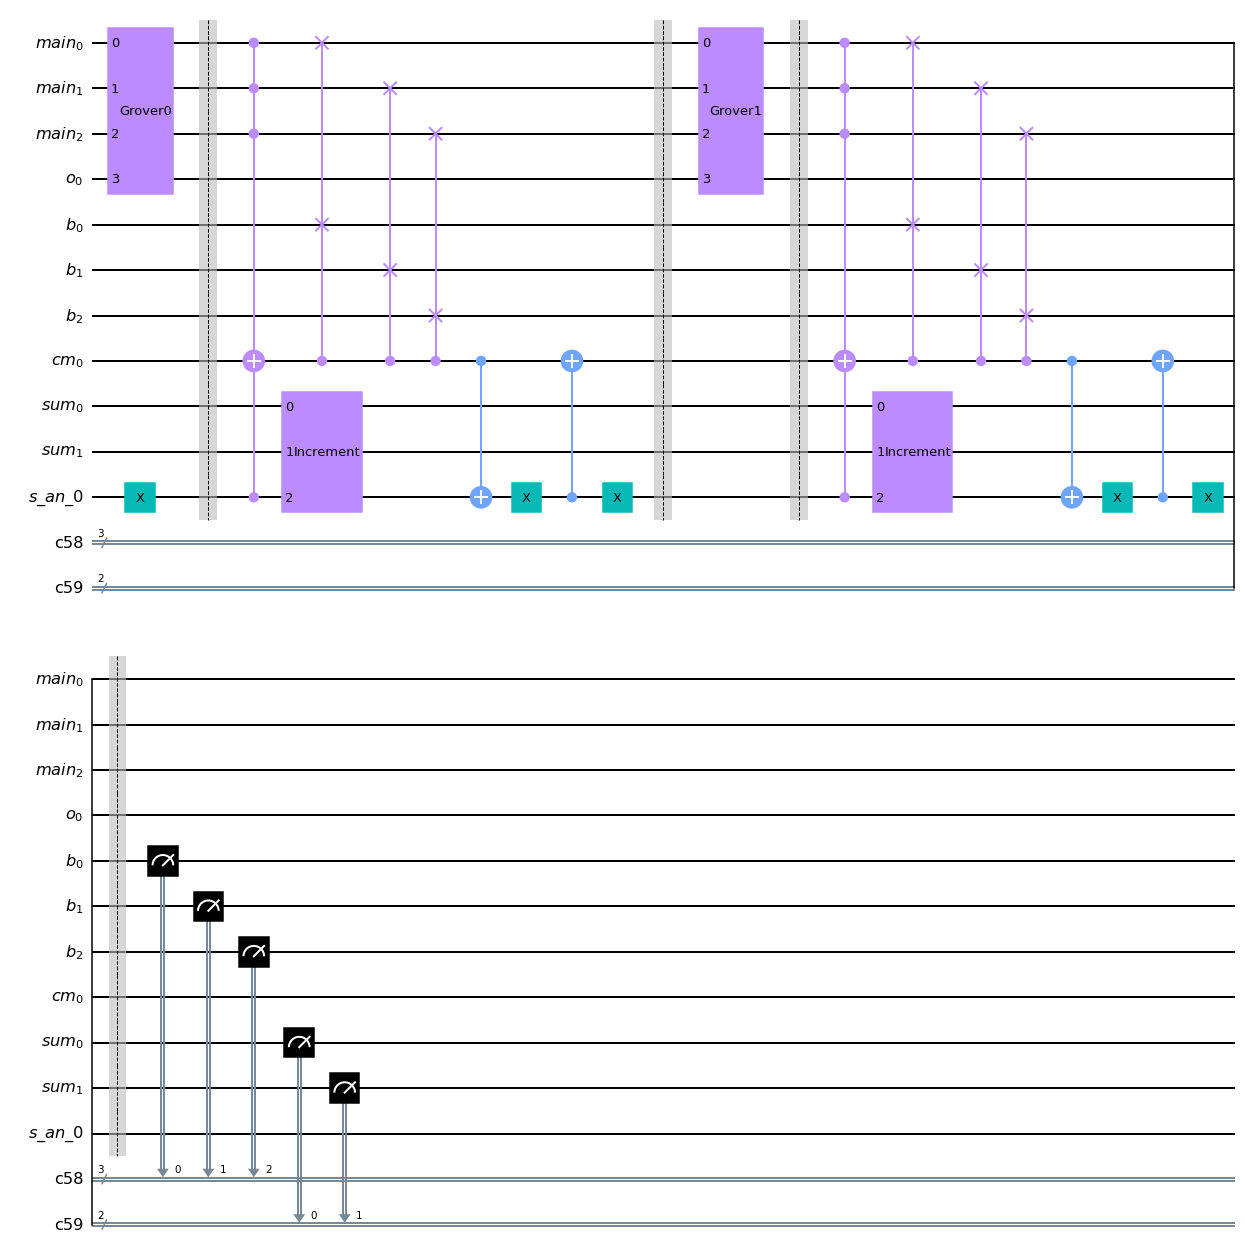

In [54]:
get_grovers(3, track_measure=True, iterations=2).draw(output='mpl')

11


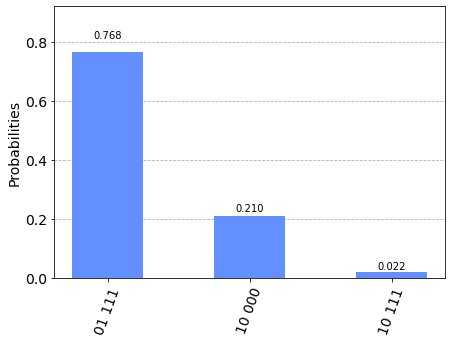

In [55]:
q = get_grovers(3, track_measure=True, iterations=2)
print(q.num_qubits)
plot_histogram(simulate(q))

Results:
- It can track at which point the solution was found, but is less reliable than normal cm (perhaps due to the wrong init state for grovers?)

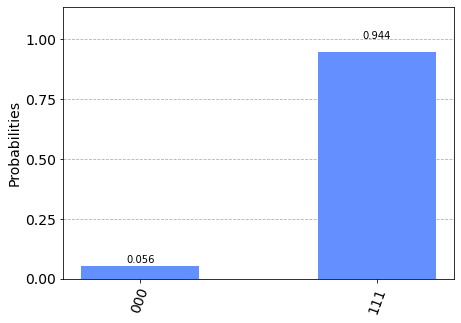

In [57]:
q = get_grovers(3, cm=True, iterations=2)
plot_histogram(simulate(q))

In [58]:
## I cant simulate more than 3 qubits:
q = get_grovers(4, track_measure=True, iterations=2)
print(q.num_qubits)
plot_histogram(simulate(q))

14


BasicAerError: 'Number of qubits 28 is greater than maximum (24) for "qasm_simulator".'

### Benchmarking (ignore for now)

In [37]:
#cmly
results = {}
for n in range(1,9):
    results[n] = {}
    print("\n n =", n)
    for it in range(min(n,math.ceil(math.sqrt(n)))):
        results[n][it] = {}
        it += 1
        shots = 1
        r = {'0'*n:""}
        qc = get_grovers(n,cm=True,iterations=it, concise=True)
        print("\n") 
        a = time.time()
        while len(r) == 1 and '0'*n in r:
            r = simulate(qc, shots=shots)
            b = time.time()
            results[n][it] = [b-a, r]
            print("\t ", it, "iterations:", ", shots: ", shots, " - ", r, '{:>20}'.format("\t(took "+ str(round(b-a, 4)) + " seconds)"))
            shots *= 2
            a = b
            if shots/it > 2:
                break
    


 n = 1


	  1 iterations: , shots:  1  -  {'1': 1} 	(took 0.0319 seconds)

 n = 2


	  1 iterations: , shots:  1  -  {'11': 1} 	(took 0.0382 seconds)


	  2 iterations: , shots:  1  -  {'00': 1} 	(took 0.0377 seconds)
	  2 iterations: , shots:  2  -  {'00': 1, '11': 1} 	(took 0.0437 seconds)

 n = 3


	  1 iterations: , shots:  1  -  {'111': 1} 	(took 0.0739 seconds)


	  2 iterations: , shots:  1  -  {'111': 1} 	(took 0.1007 seconds)

 n = 4


	  1 iterations: , shots:  1  -  {'0000': 1} 	(took 0.4215 seconds)
	  1 iterations: , shots:  2  -  {'1111': 1, '0000': 1} 	(took 0.2035 seconds)


	  2 iterations: , shots:  1  -  {'1111': 1} 	(took 0.2455 seconds)

 n = 5


	  1 iterations: , shots:  1  -  {'00000': 1} 	(took 0.5148 seconds)
	  1 iterations: , shots:  2  -  {'00000': 1, '11111': 1} 	(took 0.826 seconds)


	  2 iterations: , shots:  1  -  {'00000': 1} 	(took 0.7681 seconds)
	  2 iterations: , shots:  2  -  {'00000': 1, '11111': 1} 	(took 1.3092 seconds)


	  3 iterations: , s

KeyboardInterrupt: 

In [42]:
#normally
bad_results = {}
for n in range(1,9):
    bad_results[n] = {}
    def classic(x):
        if type(x) == list: return any(classic(y) for y in x)
        return x == "1" * n
    print("\n n =", n)
    for it in range(min(n,math.ceil(math.sqrt(n)))):
        bad_results[n][it] = {}
        it += 1
        shots = 1
        r = {}
        qc = get_grovers(n,cm=False,iterations=it)
        print("\n")
        a = time.time()
        while not classic(list(r.keys())):
            r = simulate(qc, shots=shots)
            b = time.time()
            bad_results[n][it] = [b-a, r]
            print("\t ", it, "iterations:", ", shots: ", shots, " - ", classic(list(r.keys())), '{:>20}'.format("\t(took "+ str(round(b-a, 4)) + " seconds)"))
            shots *= 2
            a = b
    


 n = 1


	  1 iterations: , shots:  1  -  False 	(took 0.0489 seconds)
	  1 iterations: , shots:  2  -  True 	(took 0.0214 seconds)

 n = 2


	  1 iterations: , shots:  1  -  True 	(took 0.0253 seconds)


	  2 iterations: , shots:  1  -  False 	(took 0.0268 seconds)
	  2 iterations: , shots:  2  -  False 	(took 0.0273 seconds)
	  2 iterations: , shots:  4  -  True 	(took 0.0255 seconds)

 n = 3


	  1 iterations: , shots:  1  -  True 	(took 0.0456 seconds)


	  2 iterations: , shots:  1  -  True 	(took 0.0694 seconds)

 n = 4


	  1 iterations: , shots:  1  -  True 	(took 0.0821 seconds)


	  2 iterations: , shots:  1  -  True 	(took 0.1318 seconds)

 n = 5


	  1 iterations: , shots:  1  -  False 	(took 0.1389 seconds)
	  1 iterations: , shots:  2  -  False 	(took 0.1303 seconds)
	  1 iterations: , shots:  4  -  False 	(took 0.1344 seconds)
	  1 iterations: , shots:  8  -  True 	(took 0.1413 seconds)


	  2 iterations: , shots:  1  -  True 	(took 0.265 seconds)


	  3 iterations: , s

In [91]:
import pickle
import datetime
r = {"normal": bad_results, "cm":results}
#pickle.dump(results, open("saved_results/pick_" + str(datetime.datetime.now()).split()[0], "wb"))